In [95]:
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os

load_dotenv('credintials.env')

True

In [3]:
# setting up the LLM

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

In [11]:
from pydantic import BaseModel, Field
from typing import Literal, List

class OrchestratorFormater(BaseModel):
    city_name: str = Field(description="The name of the city to get the weather for.")

In [15]:
import requests

def get_location_key(city_name, api_key):
    """Convert city name to AccuWeather location key"""
    url = "http://dataservice.accuweather.com/locations/v1/cities/search"
    params = {
        "apikey": api_key,
        "q": city_name
    }
    
    response = requests.get(url, params=params)
    data = response.json()

    # print(data)  # See what you're getting


    if data:
        return data[0]["Key"]  # Returns location key
    return None

In [16]:
weather_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a weather agent that provides weather information based on user queries, you should extract the city name from the user query."),
    ("user", "{query}")
])

In [17]:
weather_pipe = weather_prompt | llm.with_structured_output(OrchestratorFormater)

In [47]:
from typing import TypedDict, Annotated, operator

class State(TypedDict):
    user_query: str
    city_name: str
    completed_weather_reports: Annotated[List[str], operator.add]
    final_weather_report: str

In [48]:
def orchestrator_node(state: State):
    response = weather_pipe.invoke({"query": state["user_query"]})
    return{"city_name": response.city_name}

In [79]:
import requests
from datetime import datetime

def first_weather_source_node(state: State):
    # this node uses the AccuWeather API to get the current weather conditions for the specified city

    now = datetime.now()
    print(now)
    API_KEY = os.getenv("ACCUWEATHER_API_KEY")
    location_key = get_location_key(state["city_name"], os.getenv("ACCUWEATHER_API_KEY"))
    BASE_URL = "http://dataservice.accuweather.com"

    url = f"{BASE_URL}/currentconditions/v1/{location_key}"
    params = {
        "apikey": API_KEY,
        "details": "false",
        "language": "en-us"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    weather = data[0]

    weather_report = weather['WeatherText']
    temperature = f"{weather['Temperature']['Metric']['Value']}°{weather['Temperature']['Metric']['Unit']}"

    return {
        "completed_weather_reports": [f"Source 1 - Weather: {weather_report}, Temperature: {temperature}"]
    }
   

In [100]:
from datetime import datetime

def second_weather_source_node(state: State):

    now = datetime.now()
    print(now)
    API_KEY = os.getenv("WEATHERSTACK_API_KEY")
    BASE_URL = f"https://api.weatherstack.com/current?access_key={API_KEY}"

    query = {"query": state["city_name"]}

    response = requests.get(BASE_URL, params=query)

    data = response.json()

    temp = data['current']['temperature']
    feels_like = data['current']['feelslike']
    weather = data['current']['weather_descriptions'][0]
    humidity = data['current']['humidity']
    wind_speed = data['current']['wind_speed']
    pressure = data['current']['pressure']

    weather_report = f"temperature: {temp}, feels like: {feels_like}, weather: {weather}, humidity: {humidity}, wind speed: {wind_speed}, pressure: {pressure}"

    return {
        "completed_weather_reports": [f"Source 2 - {weather_report}"]
    } 


In [101]:
joiner_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a weather report synthesizer. You will receive multiple weather reports from different sources. Your task is to combine these reports into a single, coherent weather summary."),
    ("user", "Here are the weather reports:\n{completed_weather_reports}\nPlease provide a final summarized weather report.")
])

joiner_pipe = joiner_prompt | llm

In [102]:
def synthesizer_node(state: State):
    final_report = " | ".join(state["completed_weather_reports"])
    
    joiner_response = joiner_pipe.invoke({"completed_weather_reports": final_report})
    return {"final_weather_report": joiner_response}

In [103]:
workflow = StateGraph(State)

workflow.add_node("orchestrator_node", orchestrator_node)
workflow.add_node("first_weather_source_node", first_weather_source_node)
workflow.add_node("second_weather_source_node", second_weather_source_node)
workflow.add_node("synthesizer_node", synthesizer_node)


In [104]:
workflow.add_edge("orchestrator_node", "first_weather_source_node")
workflow.add_edge("orchestrator_node", "second_weather_source_node")
workflow.add_edge("first_weather_source_node", "synthesizer_node")
workflow.add_edge("second_weather_source_node", "synthesizer_node")
workflow.add_edge(START, "orchestrator_node")
workflow.add_edge("synthesizer_node", END)

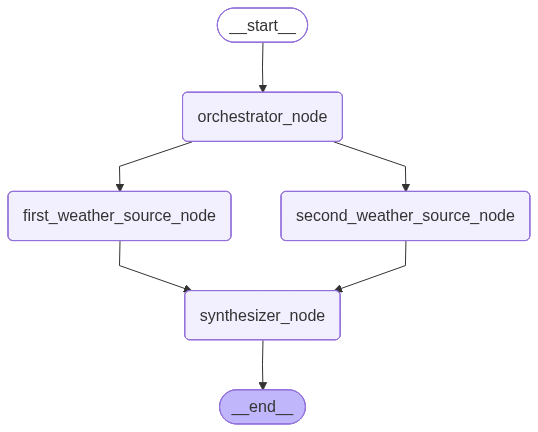

In [105]:
app = workflow.compile()
app

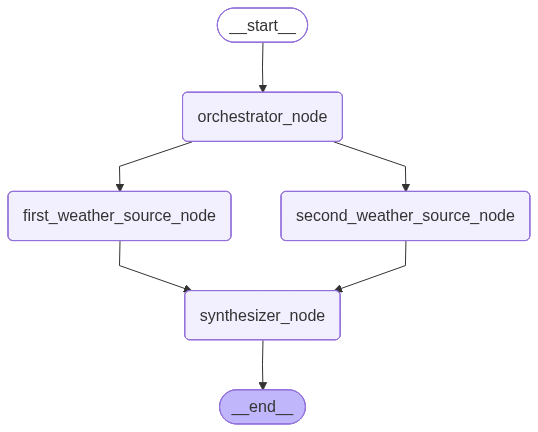

In [106]:
app

In [107]:
response = app.invoke({"user_query": "What's the weather like in london?"})

2025-10-29 15:26:36.072396
2025-10-29 15:26:36.074592


In [116]:
print(response["completed_weather_reports"])
print(response["final_weather_report"].content)

['Source 1 - Weather: Rain, Temperature: 12.1°C', 'Source 2 - temperature: 12, feels like: 11, weather: Light Drizzle And Rain, Drizzle And Rain, humidity: 94, wind speed: 12, pressure: 999']
Here's a consolidated weather report:

**Weather:** Light drizzle and rain.
**Temperature:** Approximately 12°C (feels like 11°C).
**Humidity:** 94%
**Wind Speed:** 12
**Pressure:** 999
